In [1]:
import os
import cv2
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from dotenv import load_dotenv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from train import train
from utils import (
    poly_lr_scheduler, fast_hist, per_class_iou, compute_flops, 
    get_latency_and_fps, save_results, plot_loss, plot_mIoU, plot_IoU
)

# Load environment variables
load_dotenv()
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

# Set random seed for reproducibility
torch.cuda.manual_seed(42)

# Mapping from class IDs to labels
id_to_label = {
    0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence',
    5: 'pole', 6: 'light', 7: 'sign', 8: 'vegetation', 9: 'terrain',
    10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck',
    15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle', 255: 'unlabeled'
}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ardaerendogru (aeddea). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/arda/.netrc


In [15]:
BATCH_SIZE = 6
NC=19
NUM_WORKERS = 8

def to_tensor_no_normalize(pil_image):
    # Apply the resize transformation to the image
    # Convert the PIL image to a tensor
    return torch.tensor(np.array(pil_image, dtype=np.uint8))

transform_cityscapes_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_gta5_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_label = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.Lambda(lambda img: to_tensor_no_normalize(img))
])
transform_cityscapes_label = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST),
    transforms.Lambda(lambda img: to_tensor_no_normalize(img))
])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform_image=transform_cityscapes_image , transform_label=transform_cityscapes_label)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform_image=transform_cityscapes_image , transform_label=transform_cityscapes_label)
GTA5_dataset = GTA5('./GTA5', transform_image=transform_gta5_image , transform_label=transform_label)


cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



## 2.1 DeepLabV2

In [3]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 0.001 #0.0001
model_deeplab = get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='./models/deeplab_resnet_pretrained_imagenet.pth').cuda()
optimizer_deeplab = torch.optim.Adam(model_deeplab.parameters(), lr=init_lr)

deeplab_result = train( model_deeplab,
                        loss_fn, optimizer_deeplab,
                        cityscapes_train_dataloader,
                        cityscapes_test_dataloader, 
                        5,
                        'step2_DeepLabV2')
save_results(model_deeplab, deeplab_result, "deeplab_performance_metrics_2_1", height=256, width=512, iterations=10)






Deeplab pretraining loading...


  0%|          | 0/5 [00:00<?, ?it/s]

/home/arda/anaconda3/envs/SEMSEG/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/arda/anaconda3/envs/SEMSEG/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0
Train Loss: 2.020626045820367, Validation Loss: 3.942695829130354
Train mIoU: 0.02637867947194721, Validation mIoU: 0.023286582616658988
Epoch: 1
Train Loss: 1.9587908482733574, Validation Loss: 3.426287429673331
Train mIoU: 0.02536827632386675, Validation mIoU: 0.025991592799845822
Epoch: 2
Train Loss: 1.923756042964586, Validation Loss: 2.234846824691409
Train mIoU: 0.026247527809688743, Validation mIoU: 0.023574560463081266
Epoch: 3
Train Loss: 1.871523630983047, Validation Loss: 5.291174396162941
Train mIoU: 0.027370959364733695, Validation mIoU: 0.024692163472996288
Epoch: 4
Train Loss: 1.8557365300091169, Validation Loss: 18.84401905110904
Train mIoU: 0.0282090376211249, Validation mIoU: 0.027024563260848605


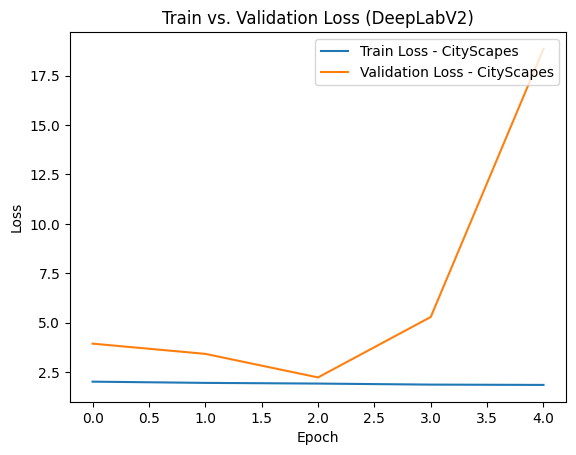

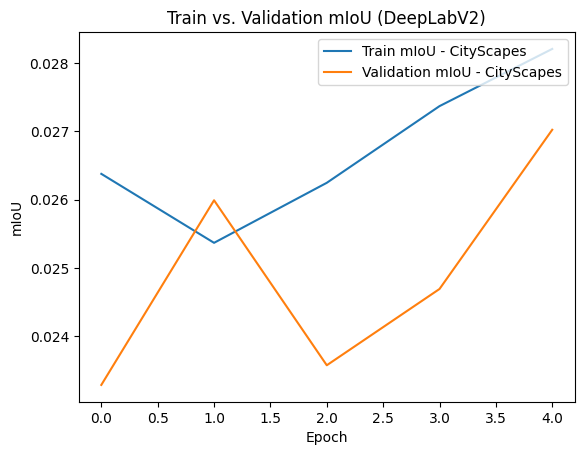

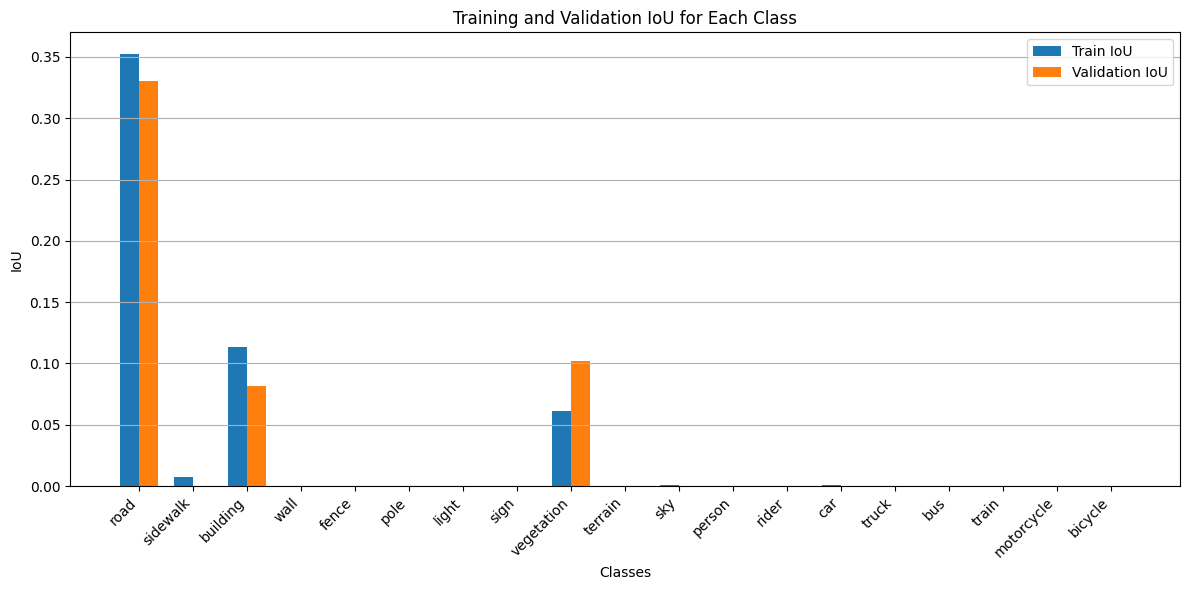

In [10]:
plot_loss(deeplab_result, "DeepLabV2", "step2.1", "CityScapes", "CityScapes")
plot_mIoU(deeplab_result, "DeepLabV2", "step2.1", "CityScapes", "CityScapes")
plot_IoU(deeplab_result, "DeepLabV2", "step2.1", "CityScapes", "CityScapes")



## 2.2 BiseNet


In [12]:
from tqdm.notebook import tqdm
from models.bisenet.build_bisenet import BiSeNet
model_bisenet = BiSeNet(20, 'resnet18').cuda()
from utils import poly_lr_scheduler, fast_hist, per_class_iou
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 0.001 #0.0001
optimizer_bisenet = torch.optim.Adam(model_bisenet.parameters(), lr=init_lr)
bisenet_result_2_2 = train(model_bisenet, loss_fn, optimizer_bisenet,cityscapes_train_dataloader,cityscapes_test_dataloader, 5,'step2_BiseNet')
save_results(model_bisenet, bisenet_result_2_2, "bisenet_performance_metrics_2_2", height=256, width=512, iterations=10)



  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: input and target batch or spatial sizes don't match: target [6, 100, 100], input [6, 20, 104, 104]

In [ ]:
plot_loss(bisenet_result_2_2, "BiSeNet", "step2.2", "CityScapes", "CityScapes")
plot_mIoU(bisenet_result_2_2, "BiSeNet", "step2.2", "CityScapes", "CityScapes")
plot_IoU(bisenet_result_2_2, "BiSeNet", "step2.2", "CityScapes", "CityScapes")



## 3.1 Bisenet

In [16]:
from tqdm.notebook import tqdm
from models.bisenet.build_bisenet import BiSeNet
model_bisenet_3_1 = BiSeNet(20, 'resnet18').cuda()
from utils import poly_lr_scheduler, fast_hist, per_class_iou
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 0.001 #0.0001
optimizer_bisenet_3_1 = torch.optim.Adam(model_bisenet_3_1.parameters(), lr=init_lr)
bisenet_result_3_1 = train(model_bisenet_3_1, loss_fn, optimizer_bisenet_3_1,GTA5_dataloader,cityscapes_test_dataloader, 50,'step3_BiseNet')
save_results(model_bisenet_3_1, bisenet_result_3_1, "bisenet_performance_metrics_3_1", height=256, width=512, iterations=10)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.6882137000846634, Validation Loss: 1.5142645566236406
Train mIoU: 0.2104467608383409, Validation mIoU: 0.11421696734677864
Epoch: 1
Train Loss: 0.42812232076407053, Validation Loss: 1.3314237630083448
Train mIoU: 0.26893098405594656, Validation mIoU: 0.13381811047138817
Epoch: 2
Train Loss: 0.36467172841516904, Validation Loss: 1.4636239047561372
Train mIoU: 0.2971269469070567, Validation mIoU: 0.12400128884191608


KeyboardInterrupt: 

In [ ]:
plot_loss(bisenet_result_3_1, "BiSeNet", "step3.1", "GTA5", "CityScapes")
plot_mIoU(bisenet_result_3_1, "BiSeNet", "step3.1", "GTA5", "CityScapes")
plot_IoU(bisenet_result_3_1, "BiSeNet", "step3.1", "GTA5", "CityScapes")


## 3.2 Bisenet with augmentation



In [47]:
import albumentations as A
from tqdm.notebook import tqdm
from models.bisenet.build_bisenet import BiSeNet
model_bisenet_3_2 = BiSeNet(20, 'resnet18').cuda()
from utils import poly_lr_scheduler, fast_hist, per_class_iou
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 0.025 #0.0001
optimizer = torch.optim.Adam(model_bisenet_3_2.parameters(), lr=init_lr)

transform = A.Compose([
    A.Resize(256, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1), p=0.5),
    A.RandomFog(p=0.5),
    A.GaussNoise(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
GTA5_dataset = GTA5('./GTA5',augmentations=transform)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

result3_1 = train(model_bisenet_3_2, loss_fn, optimizer,GTA5_dataloader,cityscapes_test_dataloader, 50,'step3_BiseNet')

NameError: name 'BATCH_SIZE' is not defined

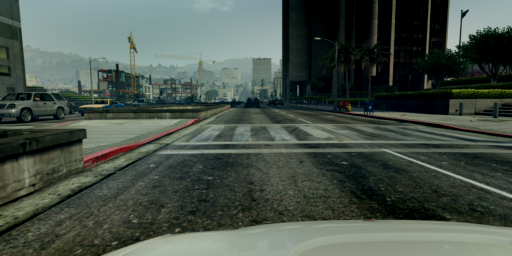

In [77]:
source_path = 'GTA5/images/00011.png'
target_path = 'Cityscapes/Cityspaces/images/val/lindau/lindau_000003_000019_leftImg8bit.png'
source = np.array(Image.open(source_path).resize((512, 256), Image.Resampling.BILINEAR))
target = np.array(Image.open(target_path).resize((512, 256), Image.Resampling.BILINEAR))
fda_transform = A.FDA(reference_images=[target], beta_limit=(0.01, 0.01), p=1,read_fn=lambda x:x)
transformed_image = fda_transform(image=source)['image']

Image.fromarray(transformed_image)



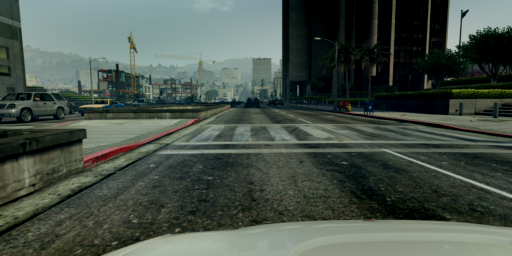

In [88]:
source.shape

(256, 512, 3)

In [21]:
np.zeros(19)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])